In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

from openpathsampling.analysis.tis_analysis import TISTransition
from openpathsampling.analysis.tis_analysis import sampleset_sample_generator

storage = paths.storage.Storage("toy_retis.nc", mode="r")

In [2]:
print len(storage.samplesets)

3000


In [3]:
retis = storage.transitions.load(0)

In [4]:
%%time
retis.move_summary(storage)
print

pathreversal ran 24.8% of the cycles with acceptance 581/744 (0.780913978495) 
shooting ran 49.2% of the cycles with acceptance 1112/1476 (0.753387533875) 
minus ran 1.43333333333% of the cycles with acceptance 42/43 (0.976744186047) 
repex ran 24.4666666667% of the cycles with acceptance 335/734 (0.456403269755) 

CPU times: user 54.3 s, sys: 1.11 s, total: 55.5 s
Wall time: 1min 2s


In [5]:
%%time
retis.move_summary(storage, 'shooting')
print

OneWayShootingMover I'face 5 ran 8.9% of the cycles with acceptance 176/267 (0.659176029963) 
OneWayShootingMover I'face 4 ran 8.5% of the cycles with acceptance 171/255 (0.670588235294) 
OneWayShootingMover I'face 1 ran 7.9% of the cycles with acceptance 200/237 (0.84388185654) 
OneWayShootingMover I'face 0 ran 8.16666666667% of the cycles with acceptance 214/245 (0.873469387755) 
OneWayShootingMover I'face 3 ran 8.96666666667% of the cycles with acceptance 204/269 (0.758364312268) 
OneWayShootingMover I'face 2 ran 6.76666666667% of the cycles with acceptance 147/203 (0.724137931034) 

CPU times: user 279 µs, sys: 68 µs, total: 347 µs
Wall time: 293 µs


In [6]:
def first_n(storage, n, trajid):
    sample_iter = sampleset_sample_generator(storage)
    first = []
    old=None
    for s in sample_iter:
        if s.replica == trajid:
            if s != old:
                first.append(s)
            old = s
        if len(first) == n:
            break
    return first

In [7]:
first40 = first_n(storage, 40, trajid=4)

In [8]:
%%time
from openpathsampling.visualize import PathTreeBuilder
from IPython.display import SVG

tree = PathTreeBuilder(storage)        
tree.rejected = True
tree.from_samples(first40)
view = tree.renderer
view.zoom = 0.8
view.scale_y = 24
view.scale_x = 14
view.font_size = 0.35

CPU times: user 1.32 s, sys: 103 ms, total: 1.42 s
Wall time: 3.15 s


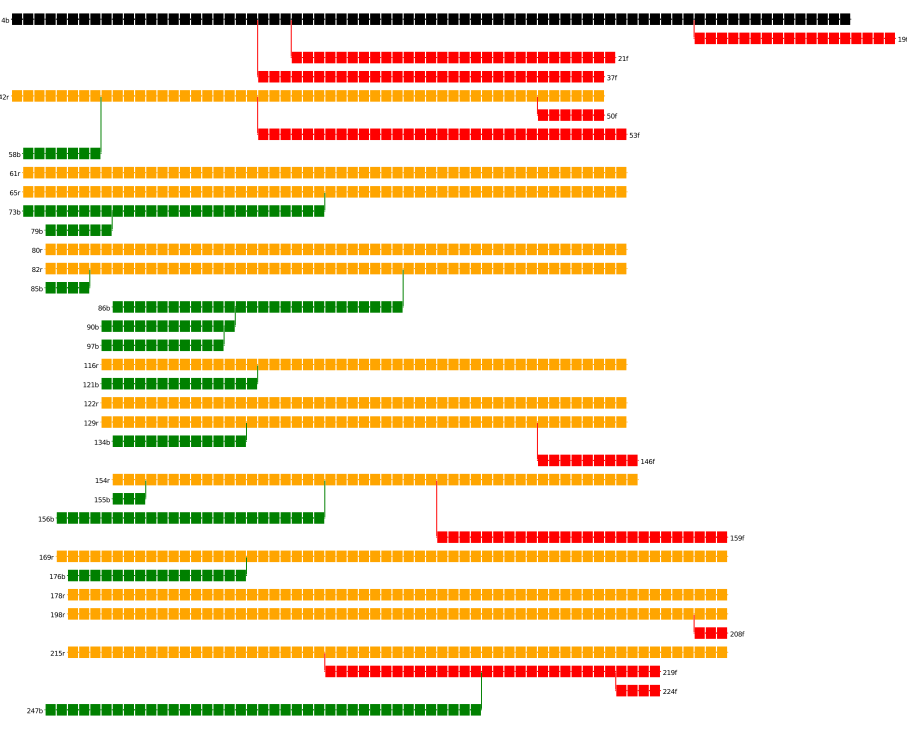

In [9]:
SVG(view.to_svg())

In [26]:
prev = first40[0].trajectory
decorrelated = [prev]
for s in first40:
    if not paths.Trajectory.correlation(s.trajectory, prev):
        decorrelated.append(s.trajectory)
        prev = s.trajectory
print "From these samples we have " + str(len(decorrelated)) + " decorrelated trajectories."

From these samples we have 15 decorrelated trajectories.


In [11]:
retis.ensemble_histogram_info['pathlength'].hist_args = { 'bin_width' : 5, 'bin_range' : (0, 150) }
retis.ensemble_histogram_info['max_lambda'].hist_args = { 'bin_width' : 0.02, 'bin_range' : (-0.35, 0.35) }

In [12]:
%%time
retis.all_statistics(storage=storage, weights=None, force=True)

CPU times: user 4min 55s, sys: 2.52 s, total: 4min 58s
Wall time: 6min


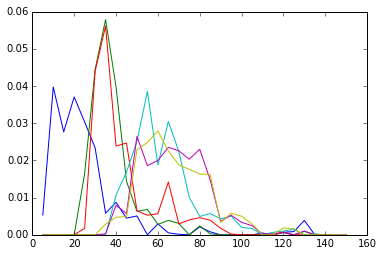

In [13]:
for ens in retis.ensembles:
    myhist = retis.histograms['pathlength'][ens]
    plt.plot(myhist.plot_bins(), myhist.normalized())

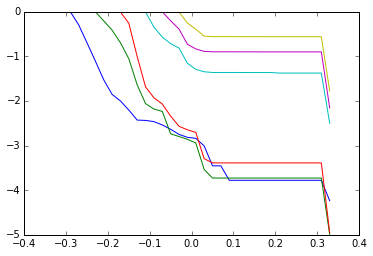

In [14]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]
    plt.plot(myhist.plot_bins(), 
             np.log(myhist.reverse_cumulative())
            )

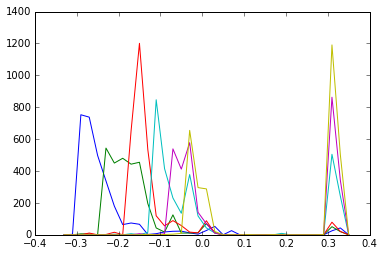

In [15]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]
    plt.plot(myhist.plot_bins(), myhist())

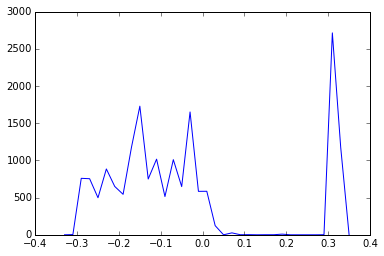

In [16]:
# TODO: add a histogram.sum_hist() function to add several histograms together
from operator import add
total_sampling = np.zeros(len(retis.histograms['max_lambda'][retis.ensembles[0]]()))
for ens in retis.ensembles:
    total_sampling = map(add, total_sampling, retis.histograms['max_lambda'][ens]())
plt.plot(myhist.plot_bins(), total_sampling);

In [17]:
from toy_plot_helpers import ToyPlot
plot = ToyPlot()
plot.add_pes(storage.engines.load(0).pes)

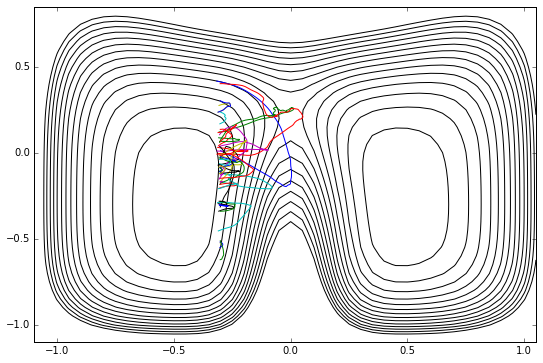

In [18]:
ens0_traj = [s.trajectory for s in storage.samples if s.ensemble == retis.ensembles[0]]
plt.contour(plot.X, plot.Y, plot._pes, levels=np.arange(0.0, 1.5, 0.1), colors='k')
for mytraj in ens0_traj[slice(None,None,15)]:
    plt.plot(mytraj.coordinates()[:,0,0], mytraj.coordinates()[:,0,1])

In [19]:
wham = retis.total_crossing_probability(method="wham")

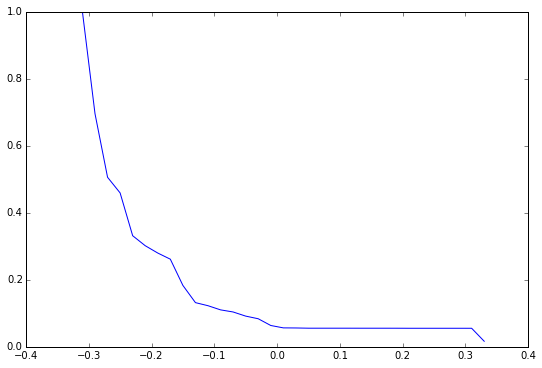

In [20]:
plt.plot(wham.keys(), wham.values());

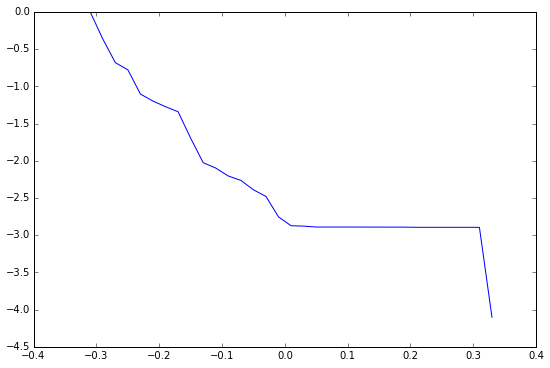

In [21]:
plt.plot(wham.keys(), np.log(wham.values()));

In [22]:
%%time
#retis.rate(storage=storage)
# TODO: conditional_transition_probability, minus_flux, rate
retis.conditional_transition_probability(storage, retis.ensembles[-1])

CPU times: user 2.46 s, sys: 38.8 ms, total: 2.5 s
Wall time: 2.6 s


0.5646666666666667

In [23]:
print retis._flux, retis.tcp(-0.05), retis.ctp[retis.ensembles[-1]]

None 0.091689466121 0.564666666667


In [25]:
#logging.getLogger("openpathsampling.ensemble").debug("test")
#flux_outside_ensemble = paths.AllOutXEnsemble(retis.minus_ensemble.innermost_vol)
#flux_inside_ensemble = paths.AllInXEnsemble(retis.minus_ensemble.innermost_vol)
minus = retis.movers['minus'][0]
for delta in storage.pathmovechanges:
    if minus in delta and delta.accepted:
        my_minus = delta
        break

delta = my_minus
print flux_outside_ensemble.split(delta.samples[1].trajectory)
print flux_inside_ensemble.split(delta.samples[1].trajectory)


[]
[Trajectory[1]]
